# References
* https://www.kaggle.com/competitions/train-an-ai-to-play-chess/overview
* https://www.kaggle.com/code/wlifferth/part-1-understanding-python-chess-and-fen
* https://www.kaggle.com/code/wlifferth/part-2-building-a-simple-chess-playing-model
* https://www.kaggle.com/code/wlifferth/part-3-making-predictions-and-submitting/notebook

In [1]:
import chess
import numpy as np
import pandas as pd
import torch
from rich import print as pprint
from torch import nn

In [2]:
train_df = pd.read_csv("../../datasets/train.csv", index_col="id")

train_df = train_df[:10000]
val_df = train_df[-1000:]

train_df.shape, val_df.shape

((10000, 3), (1000, 3))

In [3]:
train_df.head()

,board,black_score,best_move
id,,,
80091,6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118,0.0,g8d8
18578,r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...,-131.0,f3e5
11580,r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...,-490.0,g6f7
72805,8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85,-574.0,h6h5
74310,8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90,0.0,e5e6


In [4]:
def one_hot_encode_piece(piece: str) -> np.ndarray:
    pieces = list("rnbqkpRNBQKP.")
    arr = np.zeros(len(pieces), dtype=np.float32)
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr


# Let's test on a black bishop
one_hot_encode_piece("b")

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [5]:
def encode_board(board: chess.Board) -> np.ndarray:
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    board_str = board_str.replace(" ", "")
    board_list = []
    for row in board_str.split("\n"):
        row_list = [one_hot_encode_piece(piece) for piece in row]
        board_list.append(row_list)
    return np.array(board_list)

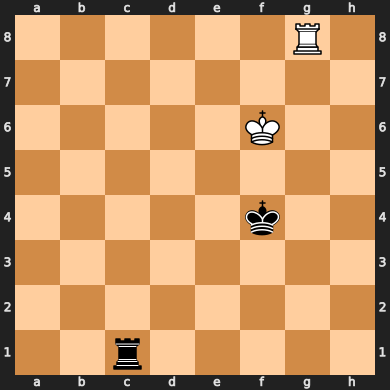

In [6]:
fen_str = train_df.iloc[0].to_dict().get("board")
board = chess.Board(fen=fen_str)
board

In [7]:
print(str(board))

. . . . . . R .
. . . . . . . .
. . . . . K . .
. . . . . . . .
. . . . . k . .
. . . . . . . .
. . . . . . . .
. . r . . . . .


In [8]:
encode_board(board)

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

    

In [9]:
def encode_fen_string(fen_str: str) -> np.ndarray:
    board = chess.Board(fen=fen_str)
    return encode_board(board)


# We'll stack all our encoded boards into a single numpy array
X_train = np.stack(train_df["board"].apply(encode_fen_string))
y_train = train_df["black_score"]


X_val = np.stack(val_df["board"].apply(encode_fen_string))
y_val = val_df["black_score"]

In [10]:
y_train

id
80091      0.0
18578   -131.0
11580   -490.0
72805   -574.0
74310      0.0
         ...  
22222    704.0
27202   -528.0
43373   -573.0
53994   -569.0
13160   -383.0
Name: black_score, Length: 10000, dtype: float64

In [11]:
torch.from_numpy(X_train[0]).shape

torch.Size([8, 8, 13])

In [12]:
class ChessModel(nn.Module):
    def __init__(self) -> None:
        super(ChessModel, self).__init__()
        self.flatten = nn.Flatten(start_dim=0, end_dim=-1)
        self.fc1 = nn.Linear(8 * 8 * 13, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ChessModel()
model(torch.from_numpy(X_train[0]))

tensor([-0.0486], grad_fn=<ViewBackward0>)

In [15]:
y_val

id
29051    363.0
65258      0.0
19530    -29.0
68027   -340.0
6988    -101.0
         ...  
22222    704.0
27202   -528.0
43373   -573.0
53994   -569.0
13160   -383.0
Name: black_score, Length: 1000, dtype: float64

In [14]:
import torch.optim as optim

# Assuming X_train, y_train, X_val, y_val are numpy arrays
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.from_numpy(y_train.values).float().unsqueeze(1)
y_val_tensor = torch.from_numpy(y_val.values).float().unsqueeze(1)


optimizer = optim.RMSprop(model.parameters())
criterion = nn.MSELoss()

epochs = 20

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x8320000 and 832x128)

In [ ]:
model

In [ ]:
t = torch.tensor([[[1, 2],
                   [3, 4]],
                  [[5, 6],
                   [7, 8]]])
# torch.flatten(t)
f = torch.flatten(t, start_dim=1, end_dim=-1)
t.shape, f.shape